## Predicting Stable Crystal Structures Using ShotgunCSP-GT

In this tutorial, we'll demonstrate how to predict the stable crystal structure of a compound based on its chemical composition. This method leverages the element-substitution-based generator (ShotgunCSP-GT), as detailed in our paper. The workflow involves four key steps:

1. **Template Structure Identification:** Retrieve all possible template structures corresponding to the given composition from a crystal structure database. In this demonstration, we use the Materials Project database.
2. **Element Substitution:** Generate a virtual library by substituting the elements in the template structures with those in the query composition.
3. **Surrogate Model Learning:** Develop a surrogate model to estimate the DFT energies of the virtual structures, and use this model to screen the candidates based on their surrogate energies.
4. **DFT Structure Relaxation:** Perform DFT-based structure relaxation on a selected subset of candidates to identify the most stable configurations.

This code is developed using Python 3.12 and has been tested on versions 3.9 through 3.12. You will need a DFT calculation backend to carry out single-point DFT calculations and DFT-based structure relaxations. In this demonstration, we use the [Vienna Ab initio Simulation Package (VASP)](https://www.vasp.at/).

### Setup Instructions

Please download the [necessary files](https://figshare.com/articles/dataset/Sample_data/26536351) to follow along with this demonstration. Once downloaded, ensure the files are organized as follows:

```
.
└── CSP_with_ShotgunCSP-GT.ipynb
└── example_data
    ├── prediction_models
    │   ├── cgcnn_formation_energy
    │   │   ├── checkpoints
    │   │   │   ├── mae.pth.s
    │   │   │   ├── mse.pth.s
    │   │   │   ├── pearsonr.pth.s
    │   │   │   └── r2.pth.s
    │   │   ├── data_indices.pkl.z
    │   │   ├── describe.pkl.z
    │   │   ├── final_state.pth.s
    │   │   ├── ft_training_plot.png
    │   │   ├── ft_training_steps.png
    │   │   ├── init_state.pth.s
    │   │   ├── model.pth.m
    │   │   ├── model_class.pkl.z
    │   │   ├── model_params.pkl.z
    │   │   ├── model_structure.pkl.z
    │   │   ├── results.csv
    │   │   ├── results.pd.xz
    │   │   ├── training_info.pd.xz
    │   │   └── val_idx.pkl.z
    │   └── composition_volume_of_primitive_cell
    │       ├── checkpoints
    │       │   ├── mae.pth.s
    │       │   ├── p_value.pth.s
    │       │   ├── pearsonr.pth.s
    │       │   ├── r2.pth.s
    │       │   └── spearmanr.pth.s
    │       ├── cv_split.pkl.z
    │       ├── data_indices.pkl.z
    │       ├── describe.pkl.z
    │       ├── final_state.pth.s
    │       ├── init_state.pth.s
    │       ├── model.pth.m
    │       ├── model_structure.pkl.z
    │       ├── ovb_plot.png
    │       ├── training_info.pd.xz
    │       ├── training_summary.csv
    │       └── training_summary.pd.xz
    ├── template_structures
    │   └── mp_structures_info.pd.xz
    └── vasp_calculation_results
        ├── opt_candidate_result.pd.xz
        └── single_point_results.pd.xz
```

By following this tutorial, you'll gain hands-on experience in using ShotgunCSP-GT to predict stable crystal structures efficiently.

#### Importing Commonly Used Packages

Before we begin, let's import the essential Python packages that will be used throughout this tutorial. These libraries provide the foundational tools needed for data manipulation, numerical computation, and visualization.

These packages are integral to the workflow, allowing us to efficiently process and visualize the data as we work through the steps of crystal structure prediction.

In [1]:
import numpy as np             # For numerical operations
import pandas as pd            # For data manipulation and analysis

import matplotlib as mpl        # For data visualization
import matplotlib.pyplot as plt

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

For this demonstration, we’ll focus on zirconium dioxide ($\mathrm{Zr}\mathrm{O}_2$) as our target compound for crystal structure prediction.
According to the Materials Project database, the stable form of $\mathrm{Zr}\mathrm{O}_2$ (mp-2858) corresponds to a primitive cell composition of $\mathrm{Zr}_4\mathrm{O}_8$.
We will apply our volume-of-primitive-cell prediction model to estimate the volume of this $\mathrm{Zr}_4\mathrm{O}_8$ structure.

**Please note that all 90 compounds have been removed from the dataset used for training our models.** 


In [2]:
from shotgun_csp.generator.utils import predict_volume

demo_target = 'Zr4O8'

predicted_volume = predict_volume(
    [demo_target],
    'example_data/prediction_models/composition_volume_of_primitive_cell',
    checkpoint='mae',
).item()
predicted_volume

140.84336853027344

#### Loading Templates

In this demonstration, we incorporate all structures, including metastable ones, from the Materials Project database as templates for generating the virtual crystal structure library.

In [3]:
# template structures
from pymatgen.core import Structure

mp_structs_info = pd.read_pickle('example_data/template_structures/mp_structures_info.pd.xz')
mp_structs_info = mp_structs_info.assign(
    structure=mp_structs_info.structure.apply(Structure.from_dict)
)

mp_structs_info.head(3)
mp_structs_info.shape

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell,structure
id,,,,,,,,,,,,,,,,,,,,
mp-10018,Ac1,{'Ac': 1.0},"(1.0,)",1.0,"(Ac,)",1,225,Fm-3m,{'Ac': {'a': 4}},"{'Ac': ('a',)}","((a,),)","(a,)","(a,)",{'Ac': {'m-3m': 4}},"{'Ac': ('m-3m',)}","((m-3m,),)","(m-3m,)","(m-3m,)",45.384600,[[0. 0. 0.] Ac]
mp-1006278,Ac1Eu1Au2,"{'Ac': 1.0, 'Eu': 1.0, 'Au': 2.0}","(1.0, 1.0, 2.0)",4.0,"(Ac, Au, Eu)",3,225,Fm-3m,"{'Ac': {'b': 4}, 'Eu': {'a': 4}, 'Au': {'c': 8}}","{'Ac': ('b',), 'Eu': ('a',), 'Au': ('c',)}","((a,), (b,), (c,))","(a, b, c)","(a, b, c)","{'Ac': {'m-3m': 4}, 'Eu': {'m-3m': 4}, 'Au': {...","{'Ac': ('m-3m',), 'Eu': ('m-3m',), 'Au': ('-43...","((-43m,), (m-3m,), (m-3m,))","(-43m, m-3m, m-3m)","(-43m, m-3m)",117.080578,"[[3.882859 3.882859 3.882859] Ac, [0. 0. 0.] E..."
mp-1008601,Zr1Ag2,"{'Zr': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Zr)",2,139,I4/mmm,"{'Zr': {'a': 2}, 'Ag': {'e': 4}}","{'Zr': ('a',), 'Ag': ('e',)}","((a,), (e,))","(a, e)","(a, e)","{'Zr': {'4/mmm': 2}, 'Ag': {'4mm': 4}}","{'Zr': ('4/mmm',), 'Ag': ('4mm',)}","((4/mmm,), (4mm,))","(4/mmm, 4mm)","(4/mmm, 4mm)",58.128751,"[[0. 0. 0.] Zr, [0. 0. 6.08155..."


(126300, 20)


#### Filtering Templates and Generated Virtual Structures

To identify candidate structures for the query composition $\mathrm{Zr}_4\mathrm{O}_8$, we first retrieved a set of crystal structures from the Materials Project database that share the same stoichiometric ratio. These template structures were then modified by substituting their original elements with those corresponding to the query composition $\mathrm{Zr}$ and $\mathrm{O}$.

The `shotgun_csp.generator.TemplateSelector` offers a robust and intuitive interface to streamline this process.

In [4]:
from shotgun_csp.generator.temple_base import TemplateSelector

TemplateSelector?

Init signature:
TemplateSelector(
    target: Union[str, pymatgen.core.composition.Composition],
    volume: float,
    *,
    volume_perturbation: float = 0.1,
    structure_matcher_params: dict = {'ltol': 0.05, 'angle_tol': 3},
)
Docstring:      <no docstring>
Init docstring:
This class selects the template structures that match the target composition and volume.

Parameters
----------
target: Union[str, Composition]
    The target composition.
volume: float
    The target volume.
volume_variance: float
    The variance of the volume. The default is 0.05.
structure_matcher_params: dict
    The parameters for the StructureMatcher. The default is dict(ltol=0.05, angle_tol=3).
File:           ~/projects/crystallus/.venv/lib/python3.10/site-packages/shotgun_csp/generator/temple_base/template.py
Type:           type
Subclasses:     

In [5]:

selector = TemplateSelector(target=demo_target, volume=predicted_volume)
selector.__call__?

Signature:
selector.__call__(
    structures: list[pymatgen.core.structure.Structure],
    n_structures: int,
    *,
    filter: Optional[shotgun_csp.generator.temple_base.filter.StructureFilter] = None,
    n_jobs: int = -1,
    verbose: bool = False,
)
Docstring:
Select the template structures that match the target composition and volume.

Parameters
----------
structures: list[Structure]
    The list of structures to select the templates.
n_structures: int
    The number of structures to generate.
filter: Union[None, StructureFilter]
    The filter to apply to the structures. The default is None.
n_jobs: int
    The number of jobs to run in parallel. The default is -1.
verbose: bool
    The flag to show the progress. The default is False.

Returns
-------
pd.DataFrame
    The DataFrame of the selected structures.
File:      ~/projects/crystallus/.venv/lib/python3.10/site-packages/shotgun_csp/generator/temple_base/template.py
Type:      method

To refine the selection of templates from the structures retrieved from the Materials Project database. Given that multiple crystals in the database may share the same prototype structure (e.g., 8,005 compounds with the same composition ratio A$_1$B$_1$C$_2$), a cluster-based template selection procedure was implemented. The goal was to select the most relevant templates for the query composition $\mathrm{Zr}_4\mathrm{O}_8$ while preserving the diversity of template structures. We utilized [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to cluster the templates, using 290-dimensional compositional descriptors generated by XenonPy to represent the chemical compositions. Only the templates that fell within the same cluster as $\mathrm{Zr}_4\mathrm{O}_8$ were selected for further analysis.


In [6]:
from shotgun_csp.generator.temple_base import DBSCANFilter

generated_structures = selector(mp_structs_info.structure, n_structures=100, filter=DBSCANFilter(verbose=True), verbose=True)

generated_structures.shape
generated_structures.head(3)

Selected 954 structures by the full formula.
  Target class number: 6
  Estimated number of clusters: 13
  Estimated number of noise points: 401
Selected 86 structures after filtering.
for spg: 1, size: 2
for spg: 2, size: 7
for spg: 4, size: 1
for spg: 10, size: 2
for spg: 11, size: 1
for spg: 12, size: 8
for spg: 14, size: 3
for spg: 15, size: 2
for spg: 18, size: 1
for spg: 29, size: 1
for spg: 60, size: 4
for spg: 62, size: 10
for spg: 63, size: 8
for spg: 70, size: 2
for spg: 74, size: 6
for spg: 87, size: 6
for spg: 88, size: 1
for spg: 111, size: 1
for spg: 141, size: 1
for spg: 160, size: 7
for spg: 205, size: 6
for spg: 227, size: 6
Selected 40 structures after removing almost identical structures.


Zr4O8:   0%|          | 0/40 [00:00<?, ?it/s]

(1009, 4)

,structure,structure_group,space_group,space_group_num
0,"[[1.00130751 1.27273431 2.0699923 ] Zr, [5.147...",0,P1,1
1,"[[1.00708338 1.28007586 2.0819327 ] Zr, [5.177...",0,P1,1
2,"[[1.00284874 1.27469332 2.07317847] Zr, [5.155...",0,P1,1


Save generated virtual structures

In [11]:
from pathlib import Path


Path('generated').mkdir(exist_ok=True)
generated_structures.to_pickle(f'generated/generated_structures.pd.xz')

### Selection of Unoptimized Structures and Generation of VASP Inputs for single-point calculation

We randomly selected 10 generated structures (*N_UNOPT=10*) from each template group and prepared their VASP inputs for single-point calculations, also known as self-consistent field (SCF) calculations.

Before generating the VASP inputs, ensure that the VASP potentials are correctly configured according to the [pymatgen documentation](https://pymatgen.org/installation.html#potcar-setup).

In [12]:
N_UNOPT = 10

single_point_candidate = generated_structures.groupby('structure_group').sample(N_UNOPT, replace=True)
single_point_candidate.to_pickle(f'generated/single_point_candidate.xz.pd')

: 

In [13]:
from shotgun_csp.utils.vasp import VASPInputGenerator

generator = VASPInputGenerator(save_to='generated/vasp_input')

for i, data in generated_structures.iterrows():
    # generate static calculation
    generator.static_input(data.structure, path_prefix=f'{i}')

If everything goes smoothly, you will find the generated VASP input files in the `generated/vasp_input` directory, with folder names like `xx_ZrO2`.

At this stage, users should perform single-point DFT energy calculations to create a training dataset of structure-energy instances for the transfer learning process. We assume that the DFT calculations have already been completed, with the results saved in the file `example_data/vasp_calculation_results/single_point_results.pd.xz`. The result should include `structure` and `formation_energy_per_atom` at least.

For users who are not comfortable performing DFT calculations, this sample code includes a set of VASP calculation results from our study. Please note that the provided structure data may differ from the ones generated above, as this code is intended for demonstration purposes only. Additionally, only successfully converged structures have been included.

### Training the Surrogate Model Using Single-Point Calculation Results

As detailed in our paper, a transferred energy prediction model was employed for exhaustive virtual screening. The global energy prediction model, based on the CGCNN architecture, was trained on 126,210 stable and unstable crystal structures, with their formation energies sourced from the Materials Project. The 90 benchmark crystals were excluded from the training dataset.

In [14]:
single_point_results = pd.read_pickle('example_data/vasp_calculation_results/single_point_results.pd.xz')
single_point_results = single_point_results.assign(
    structure=single_point_results.structure.apply(Structure.from_dict)
)

single_point_results.head(3)

,structure,target_formula,space_group,space_group_num,dissimilarity,formation_energy_per_atom,final_energy_per_atom
13345,"[[0.84004836 1.40161604 5.96268943] Zr, [0.840...",Zr4O8,Pnma,62,0.992863,-3.327849,-9.475720
13346,"[[3.52539762 1.39721872 1.44301614] Zr, [1.316...",Zr4O8,P2_12_12,18,0.636794,-3.301080,-9.448950
13347,"[[0.97438125 1.01791271 1.98775428] Zr, [5.167...",Zr4O8,P1,1,2.121633,-0.954553,-7.102423


In [16]:
import warnings

from shutil import copyfile
from itertools import product

from torch.utils.data import DataLoader
from shotgun_csp.datatools import Splitter
from shotgun_csp.descriptor import CrystalGraphFeaturizer


from shotgun_csp.model import regression_metrics
from shotgun_csp.model.training import Trainer, MSELoss, Adam, Checker, ClipValue
from shotgun_csp.model.extension import Validator, TensorConverter, Persist
from shotgun_csp.model.training.dataset import CrystalGraphDataset
from shotgun_csp.model import CrystalGraphConvNet

In [17]:
def cv_plot(pred, true, pred_fit=None, true_fit=None, *, unit='', lim=None, title='', ax=None, style='seaborn-v0_8-notebook', **kwargs):
    """
    Plot the cross-validation results.
    """
    pred, true = pred.flatten(), true.flatten()
    scores = regression_metrics(true, pred)

    with mpl.style.context(style):
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 8), dpi=100)

        if pred_fit is not None and true_fit is not None:
            ax.scatter(pred_fit, true_fit, alpha=0.5,
                       s=5, label='Train', **kwargs)
        ax.scatter(pred, true, alpha=0.6, s=8, label='Test', **kwargs)
        if lim is not None:
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
        else:
            lim = ax.get_xlim()
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)

        ax.plot(lim, lim, ls="--", c="0.3", alpha=0.7, lw=1)
        if unit != '':
            unit = f' ({unit})'
        ax.set_xlabel(f'Prediction{unit}', fontsize='x-large')
        ax.set_ylabel(f'Observation{unit}', fontsize='x-large')
        legend = ax.legend(markerscale=2, fontsize='larger', loc=0)
        for lh in legend.legendHandles:
            lh.set_alpha(1.0)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.set_title(title, fontsize='x-large')
        shift = (lim[1] - lim[0]) / 50
        ax.text(lim[1] - shift, lim[0] + shift,
                'R2: %.5f\nMAE: %.5f\nRMSE: %.5f\nPearsonR: %.5f\nSpearmanR: %.5f' % (
                    scores['r2'], scores['mae'], scores['rmse'], scores['pearsonr'], scores['spearmanr']),
                horizontalalignment='right', verticalalignment='bottom', fontsize='larger',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.tick_params(axis='both', which='major', labelsize='larger')

        return ax

##### Prepare CGCNN descriptors

In [18]:
cg_featurizer = CrystalGraphFeaturizer(
    atom_feature='origin', radius=8, n_jobs=-1
)

# calculate cgcnn features for all structures
screen_cgcnn_features = cg_featurizer.transform(generated_structures.structure)
screen_cgcnn_features.to_pickle(str(f'generated/generated_structures_cgcnn_features.pd'))

# calculate cgcnn features for single-point calculation structures
scf_cg_features = cg_featurizer.transform(single_point_results.structure)
scf_cg_features.to_pickle(str(f'generated/single_point_cgcnn_features.pd'))

##### Fine-tuning

In [19]:
# prepare training
data_size = scf_cg_features.shape[0]
if data_size <= 10:
    splitter = Splitter(data_size, test_size=2, random_state=100)
else:
    splitter = Splitter(data_size, test_size=0.1, random_state=100)
x_train, x_test, y_train, y_test = splitter.split(
    scf_cg_features, single_point_results.formation_energy_per_atom.to_frame())
train_dataloader = DataLoader(CrystalGraphDataset(x_train, y_train), shuffle=False,
                              batch_size=256, collate_fn=CrystalGraphDataset.collate_fn)
val_dataloader = DataLoader(CrystalGraphDataset(x_test, y_test),
                            batch_size=2000, collate_fn=CrystalGraphDataset.collate_fn)

# set training parameters
warnings.filterwarnings('ignore')

====== lr: 0.006; clip: 0.006 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 179
====== lr: 0.006; clip: 0.004 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 245
====== lr: 0.004; clip: 0.006 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 174
====== lr: 0.004; clip: 0.004 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 146


'generated/transferred_model/ft_training_best_mae.png'

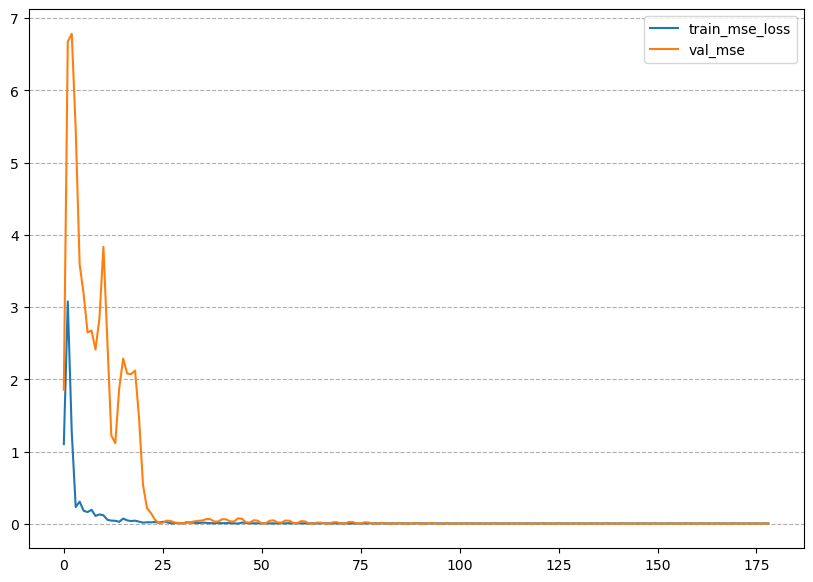

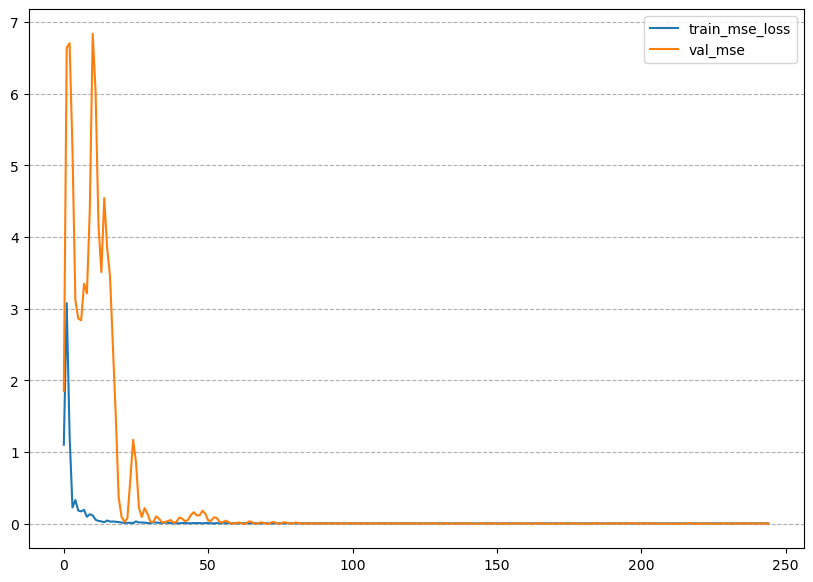

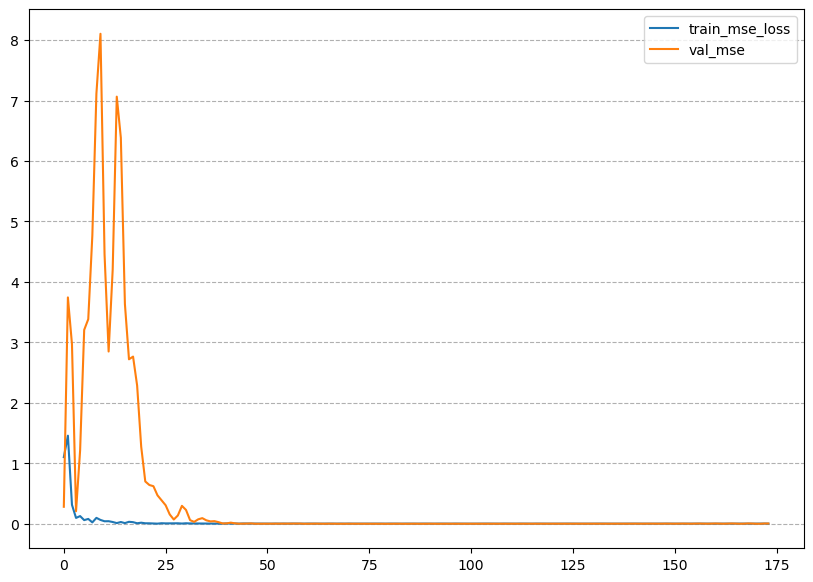

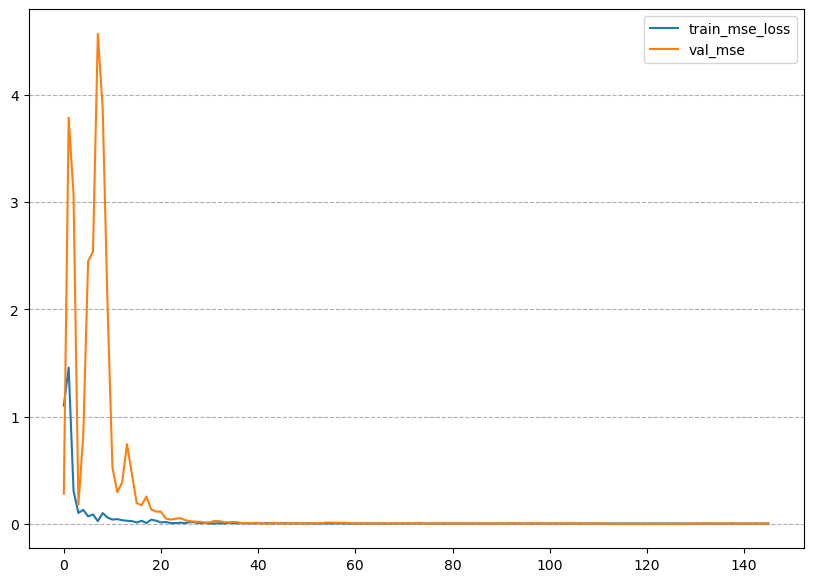

In [20]:
# global model
model_path = 'example_data/prediction_models/cgcnn_formation_energy'

# fine-tuning parameter
params = [0.01, 0.008, 0.006, 0.004, 0.002]

# max epochs
epochs = 400


# model training with grid search for learning rate and gradient clipping 
summary = []
for lr, clip in product(params, params):

    checker = Checker(model_path)
    trainer = Trainer.from_checker(
        checker=checker,
        cuda=True,
        optimizer=Adam(lr=lr),
        loss_func=MSELoss(),
        clip_grad=ClipValue(clip)
    ).extend(
        TensorConverter(empty_cache=True),
        Validator(metrics_func=regression_metrics, early_stopping=20,
                  trace_order=1, pearsonr=1.0, mse=0.0, r2=0.0, mae=0.0),
    )

    persist = Persist(
        increment=True,
        path=f'generated/transferred_model/model',
        model_class=CrystalGraphConvNet,
        model_params=checker.model_params,
        dataset_detail='vasp-6.1.2'
    )
    trainer.extend(persist).reset(to='mae')

    print(f"====== lr: {lr}; clip: {clip} ===========")
    trainer.fit(training_dataset=train_dataloader,
                validation_dataset=val_dataloader, epochs=epochs, checkpoint=True)

    persist(splitter=splitter, data_indices=single_point_results.index.tolist())
    training_info = trainer.training_info

    # draw training steps
    f, ax = plt.subplots(figsize=(10, 7), dpi=100)
    ax = trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)
    _ = ax.grid(axis='y', linestyle='--')
    f.savefig(f'{persist.path}/ft_training_steps.png',
              bbox_inches='tight', dpi=300)

    # draw OvP
    pred, true = trainer.predict(dataset=val_dataloader, checkpoint='mae')
    pred_fit, true_fit = trainer.predict(
        dataset=train_dataloader, checkpoint='mae')

    _ = cv_plot(pred, true, pred_fit, true_fit)
    plt.savefig(f'{persist.path}/ft_training_plot.png',
                bbox_inches='tight', dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

    summary.append(dict(
        path=persist.path,
        data_size=data_size,
        lr=lr,
        clip=clip,
        mae=training_info['val_mae'].min(),
        mse=training_info['val_mse'].min(),
        r2=training_info['val_r2'].max(),
        corr=training_info['val_pearsonr'].max(),
    ))
    pd.DataFrame(summary).to_csv(
        'generated/transferred_model/training_summary.pd.csv')

summary = pd.DataFrame(summary)
summary.to_pickle('generated/transferred_model/training_summary.pd.xz')

best_mae = summary.sort_values('mae').iloc[0].path
copyfile(f'{best_mae}/ft_training_plot.png',
         'generated/transferred_model/ft_training_best_mae.png')

##### Prediction and Virtual Screening

We ultimately selected 100 virtual structures for DFT-based structure optimization. Specifically, we first identified the predicted lowest-energy structures from each template group and used them to rank the template groups in ascending order of energy. From the top 20 template groups (*N_GROUP = 20*), the 5 lowest-energy structures (*N_OPT = 5*) were selected for further optimization.

In [22]:
N_GROUP = 20
N_OPT = 5

In [23]:
best_mae_path = pd.read_pickle(
    'generated/transferred_model/training_summary.pd.xz').sort_values('mae').iloc[0].path
trainer = Trainer.from_checker(checker=best_mae_path, cuda=True).extend(
    TensorConverter(empty_cache=True))

# prediction
val_dataloader = DataLoader(
    CrystalGraphDataset(
            screen_cgcnn_features,
            np.zeros(screen_cgcnn_features.shape[0]).reshape(-1, 1)
        ),
        batch_size=500, collate_fn=CrystalGraphDataset.collate_fn
    )

pred, _ = trainer.predict(dataset=val_dataloader, checkpoint='mae')

# load screen structures
generated_structures = pd.read_pickle('generated/generated_structures.pd.xz')
generated_structures = generated_structures.assign(prediction=pred)
generated_structures.drop(columns='structure').to_pickle(
    'generated/generated_structures_with_prediction.pd.xz')

generated_structures = generated_structures[generated_structures.prediction < 0]
groups = generated_structures.groupby('structure_group')[
    ['prediction']].min().sort_values('prediction').index[:N_GROUP]
opt_candidate = generated_structures[generated_structures.structure_group.isin(groups)].groupby(
    'structure_group').apply(lambda x: x.sort_values('prediction').head(N_OPT)).droplevel('structure_group')
opt_candidate.to_pickle('generated/opt_candidate.pd.xz')

opt_candidate.shape

(89, 6)

#### Selection of Final Candidates

DFT structural optimization will be performed on the candidate structures stored in `generated/opt_candidate.pd.xz` to predict the crystal structure of $\mathrm{Zr}_4\mathrm{O}_8$. Similar to generating VASP inputs for single-point calculations, you can use the `VASPInputGenerator` to create VASP inputs for structure relaxation. Users are responsible for carrying out the structure optimization.

In [25]:
from shotgun_csp.utils.vasp import VASPInputGenerator

generator = VASPInputGenerator(save_to='generated/vasp_input')

for i, data in opt_candidate.iterrows():
    # generate static calculation
    generator.relax_input(data.structure, path_prefix=f'{i}')

In [26]:
final_result = pd.read_pickle('example_data/vasp_calculation_results/opt_candidate_result.pd.xz')
final_result = final_result.assign(
    structure=final_result.structure.apply(Structure.from_dict)
)

final_result.head(3)

,formula_pretty,formation_energy_per_atom,final_energy_per_atom,structure_group,target_formula,structure,converged
id,,,,,,,
1059,ZrO2,-7.901437,-9.438405,8,Zr4O8,[[2.61332090e+00 2.61332090e+00 3.20039507e-16...,True
967,ZrO2,-7.901465,-9.438433,8,Zr4O8,[[2.61330891e+00 2.61330891e+00 3.20038039e-16...,True
65,ZrO2,-7.982247,-9.519214,2,Zr4O8,"[[3.66157261 1.3074229 1.49870806] Zr, [1.370...",True


The top 5 structures (*N_STRUCT = 5*) with the lowest formation energy for each template are selected as the final candidates.

In [28]:
N_STRUCT = 5

final_result = final_result.sort_values(
    'formation_energy_per_atom').groupby('structure_group').head(N_STRUCT)
final_result = final_result.assign(
    space_group_num=final_result.structure.apply(
        lambda s: s.get_space_group_info()[1]),
)

final_result.to_pickle('generated/final_proposed_structures.pd.xz')
final_result

,formula_pretty,formation_energy_per_atom,final_energy_per_atom,structure_group,target_formula,structure,converged,space_group_num
id,,,,,,,,
5,ZrO2,-8.056902,-9.593870,0,Zr4O8,"[[2.85272939 3.70408311 4.44153828] Zr, [0.228...",True,14
7,ZrO2,-8.056900,-9.593868,0,Zr4O8,"[[2.85291178 3.70391033 4.44185941] Zr, [0.227...",True,14
0,ZrO2,-8.056898,-9.593866,0,Zr4O8,"[[2.85307367 3.70349685 4.4420747 ] Zr, [0.227...",True,14
2,ZrO2,-8.056889,-9.593857,0,Zr4O8,"[[2.85220447 3.70270231 4.4411749 ] Zr, [0.227...",True,14
12,ZrO2,-8.056889,-9.593857,0,Zr4O8,"[[2.85218545 3.70275872 4.44111552] Zr, [0.227...",True,14
33,ZrO2,-8.032976,-9.569944,1,Zr4O8,"[[1.35623771 1.22996757 0.1635448 ] Zr, [1.356...",True,29
29,ZrO2,-8.032967,-9.569934,1,Zr4O8,"[[1.35621643 1.23036135 0.16409659] Zr, [1.356...",True,29
30,ZrO2,-8.032957,-9.569925,1,Zr4O8,"[[1.35670995 1.23153948 0.163581 ] Zr, [1.356...",True,29
25,ZrO2,-8.032949,-9.569917,1,Zr4O8,"[[1.35719055 1.23255449 0.16429115] Zr, [1.357...",True,29


The proposed structures with id 5, 7, 0, 2, and 12 have the same crystalline structure as the ground truth.